<a href="https://colab.research.google.com/github/adoptioncntr/Minesweeper/blob/main/Minesweeper_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minesweeper Deep Learning - Task 1 (IMPROVED)
## Rutgers CS 462 - Fall 2025



## 1. Setup

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Running locally")
#CUDA absolutely necessary for this project
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from typing import List, Tuple, Set, Dict
from tqdm.auto import tqdm
import copy
import pickle

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8) #standard figure size

SEED = 42 #need seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Minesweeper Environment

In [ ]:
class MinesweeperGame:
    """
    here i implement the Minesweeper game logic.

    - Where mines are located (hidden from player)
    - What the player has revealed so far
    - Clue numbers (how many adjacent mines each cell has)

    """

    def __init__(self, height=22, width=22, num_mines=80):
        """
        Initialize the game board.
        """
        self.height = height
        self.width = width
        self.num_mines = num_mines
        self.reset()  #set up a new game

    def reset(self):
        """
        the function returns:
            initial game state (what the player sees after first move)
        """
        #Create empty board
        # dtype=bool means each cell is true (mine) or false (safe)
        self.mine_map = np.zeros((self.height, self.width), dtype=bool)


        positions = [(i, j) for i in range(self.height) for j in range(self.width)]

        # here i randomly select positions for mines
        mine_positions = random.sample(positions, self.num_mines)

        #place mines at selected positions
        for i, j in mine_positions:
            self.mine_map[i, j] = True

        #calculate clue numbers
        # note that clues range from 0-8 (a cell has at most 8 neighbors)
        self.clue_map = np.zeros((self.height, self.width), dtype=int)
        for i in range(self.height):
            for j in range(self.width):
                if not self.mine_map[i, j]:  #only compute clues for safe cells
                    self.clue_map[i, j] = self._count_adjacent_mines(i, j)

        #track which cells the player has revealed
        #Initially all false (nothing revealed yet)
        self.revealed = np.zeros((self.height, self.width), dtype=bool)


        self.game_over = False
        self.mine_triggered = False
        self.num_revealed = 0


        self._reveal_first_cell()

        return self.get_state()

    def _count_adjacent_mines(self, i, j):

        count = 0

        # Check all 8 directions (or fewer if on edge/corner)
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue  # Skip the cell itself

                # Calculate neighbor position
                ni, nj = i + di, j + dj

                #check if neighbor is within board bounds
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    if self.mine_map[ni, nj]:
                        count += 1

        return count

    def _reveal_first_cell(self):


        zero_cells = [(i, j) for i in range(self.height)
                      for j in range(self.width)
                      if self.clue_map[i, j] == 0]

        if zero_cells:

            i, j = random.choice(zero_cells)
        else:

            non_mine_cells = [(i, j) for i in range(self.height)
                             for j in range(self.width)
                             if not self.mine_map[i, j]]
            i, j = random.choice(non_mine_cells)


        self._reveal_cell_and_neighbors(i, j)

    def _reveal_cell_and_neighbors(self, i, j):

        if self.revealed[i, j]:
            return
          # Mark as revealed
        self.revealed[i, j] = True
        self.num_revealed += 1


        if self.clue_map[i, j] == 0:
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue

                    ni, nj = i + di, j + dj


                    if 0 <= ni < self.height and 0 <= nj < self.width:

                        if not self.revealed[ni, nj] and not self.mine_map[ni, nj]:
                            self._reveal_cell_and_neighbors(ni, nj)  # RECURSION!

    def step(self, i, j):


        if self.game_over:
            return self.get_state(), 0, True, {'mine_triggered': self.mine_triggered}


        if self.revealed[i, j]:
            return self.get_state(), 0, False, {}

        # Hit a mine boooom
        if self.mine_map[i, j]:
            self.revealed[i, j] = True
            self.num_revealed += 1
            self.game_over = True
            self.mine_triggered = True
            reward = -1  #negative reward for hitting mine
            return self.get_state(), reward, True, {'mine_triggered': True}


        self._reveal_cell_and_neighbors(i, j)


        total_safe_cells = self.height * self.width - self.num_mines
        if self.num_revealed == total_safe_cells:
            self.game_over = True
            reward = 10
        else:
            reward = 1

        return self.get_state(), reward, self.game_over, {'mine_triggered': False}

    def get_state(self):
        """
        Get what the player can currently see.

        Returns:
            numpy array of shape (22, 22) where:
                -1 = unrevealed cell (player doesn't know what's there)
                0-8 = revealed cell showing clue number

        Note: This hides mine locations The player never sees self.mine_map
        """

        state = np.full((self.height, self.width), -1, dtype=int)

        state[self.revealed] = self.clue_map[self.revealed]

        return state

    def get_neighbors(self, i, j):
        """
        Get list of all valid neighbor positions for cell (i, j).

        Useful for logic reasoning - "what cells are adjacent to this one?"

        Returns:
            List of (row, col) tuples for neighbors
        """
        neighbors = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue

                ni, nj = i + di, j + dj

                if 0 <= ni < self.height and 0 <= nj < self.width:
                    neighbors.append((ni, nj))

        return neighbors

print("Minesweeper environment created successfully")

Minesweeper environment created successfully


## 3. Logic Bot

In [ ]:
class LogicBot:
    """Baseline logic bot. WHat my logic bot attempts:
      1. Look at revealed cells with clue numbers
    2. Apply two simple rules:
       - Rule 1: If clue = unrevealed neighbors, all neighbors are mines
       - Rule 2: If (total neighbors - clue) = unrevealed neighbors, all are safe
    3. Repeat until no new inferences possible
    4. If stuck, guess randomly
    """
    def __init__(self, game: MinesweeperGame):
        self.game = game
        self.height = game.height
        self.width = game.width
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.cells_remaining = set((i, j) for i in range(self.height)
                                   for j in range(self.width))

    def play_game(self, allow_continue_after_mine=False):
        state = self.game.reset()
        self._update_from_state(state)

        num_mines_triggered = 0
        moves_history = []

         # Main game loop
        while not self.game.game_over:
            self._make_inferences(state)

            if self.inferred_safe:
                i, j = self.inferred_safe.pop()
            else:
                if not self.cells_remaining:
                    break
                i, j = random.choice(list(self.cells_remaining))

            state, reward, done, info = self.game.step(i, j)
            moves_history.append((i, j, info.get('mine_triggered', False)))

            if info.get('mine_triggered'):
                num_mines_triggered += 1
                if not allow_continue_after_mine:
                    break
              #update internal tracking
            self._update_from_state(state)

        return self.game.num_revealed, num_mines_triggered, moves_history

    def _update_from_state(self, state):
        for i in range(self.height):
            for j in range(self.width):
                if state[i, j] >= 0:
                    self.cells_remaining.discard((i, j))
                    self.inferred_safe.discard((i, j))
                    self.inferred_mine.discard((i, j))

    def _make_inferences(self, state):
        made_inference = True

        while made_inference:
            made_inference = False

            for i in range(self.height):
                for j in range(self.width):
                    if state[i, j] < 0:
                        continue

                    clue = state[i, j]
                    neighbors = self.game.get_neighbors(i, j)

                    unrevealed_neighbors = []
                    inferred_mine_neighbors = 0
                    revealed_or_safe_neighbors = 0

                    for ni, nj in neighbors:
                        if (ni, nj) in self.inferred_mine:
                            inferred_mine_neighbors += 1
                        elif state[ni, nj] >= 0 or (ni, nj) in self.inferred_safe:
                            revealed_or_safe_neighbors += 1
                        else:
                            unrevealed_neighbors.append((ni, nj))

                    if clue - inferred_mine_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_mine:
                                self.inferred_mine.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True

                    total_neighbors = len(neighbors)
                    if (total_neighbors - clue) - revealed_or_safe_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_safe:
                                self.inferred_safe.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True

print("Logic Bot created successfully")

Logic Bot created successfully


## 4. Data Generation Functions

In [ ]:
def state_to_tensor(state):
    """Convert game state to tensor with 3 channels
      3 channels:
    - channel 0: revealed mask (1=revealed, 0=hidden)
    - channel 1: clue numbers normalized to 0-1
    - channel 2: unrevealed mask (what we need to predict)"""
    revealed_mask = (state >= 0).astype(np.float32)
    clue_normalized = np.where(state >= 0, state / 8.0, 0).astype(np.float32)
    unrevealed_mask = (state < 0).astype(np.float32)

    tensor = np.stack([revealed_mask, clue_normalized, unrevealed_mask], axis=0)
    return torch.from_numpy(tensor)


def generate_training_data_improved(num_games=1000, difficulty='medium', use_logic_bot=True):
    """
    IMPROVED data generation using Logic Bot games for better quality data

    Args:
        num_games: Number of games to generate
        difficulty: 'easy', 'medium', or 'hard'
        use_logic_bot: If True, use logic bot games; if False, use random games
    """
    if difficulty == 'easy':
        num_mines = 50
    elif difficulty == 'medium':
        num_mines = 80
    else:
        num_mines = 100

    game = MinesweeperGame(num_mines=num_mines)

    states = []
    targets = []
    masks = []

    for _ in tqdm(range(num_games), desc=f"Generating {difficulty} data"):
        if use_logic_bot:
            # Use logic bot to generate higher quality trajectories
            bot = LogicBot(game)
            state = game.reset()
            bot._update_from_state(state)

            for step in range(100):
                if game.game_over:
                    break

                # Save current state
                target = game.mine_map.astype(np.float32)
                mask = (state < 0).astype(np.float32)

                if mask.sum() > 0:
                    states.append(state_to_tensor(state))
                    targets.append(torch.from_numpy(target))
                    masks.append(torch.from_numpy(mask))

                # Logic bot makes move
                bot._make_inferences(state)
                if bot.inferred_safe:
                    i, j = bot.inferred_safe.pop()
                else:

                    unrevealed = [(i, j) for i in range(game.height) for j in range(game.width) if state[i, j] < 0]
                    if not unrevealed:
                        break
                    i, j = random.choice(unrevealed)

                state, _, _, _ = game.step(i, j)
                bot._update_from_state(state)
        else:
            # Random games (original approach)
            game.reset()
            for step in range(50):
                if game.game_over:
                    break

                state = game.get_state()
                target = game.mine_map.astype(np.float32)
                mask = (state < 0).astype(np.float32)

                if mask.sum() > 0:
                    states.append(state_to_tensor(state))
                    targets.append(torch.from_numpy(target))
                    masks.append(torch.from_numpy(mask))

                unrevealed = [(i, j) for i in range(game.height) for j in range(game.width) if state[i, j] < 0]
                if not unrevealed:
                    break

                i, j = random.choice(unrevealed)
                game.step(i, j)

    return states, targets, masks


class MinesweeperDataset(Dataset):
    def __init__(self, states, targets, masks):
        self.states = states
        self.targets = targets
        self.masks = masks

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.targets[idx], self.masks[idx]

print("Data generation functions ready")

Data generation functions ready


## 5. Improved Neural Network with Dropout

In [ ]:
class ResidualBlock(nn.Module):
    """
    residual block with dropout

    dropout = regularization to prevent overfitting
    we had MASSIVE overfitting issues without this!
    """
    def __init__(self, channels, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.dropout = nn.Dropout2d(dropout)  # THIS IS KEY - prevents memorization
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x  # save input
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # randomly drop some activations during training
        x = self.bn2(self.conv2(x))
        x = x + residual  # add input back (residual connection)
        x = F.relu(x)
        return x


class MinesweeperResNet(nn.Module):
    """
    ResNet for minesweeper

    Uses:
    - Residual blocks (for deeper network)
    - Dilated convolutions (to see farther across board)
    - Dropout (to prevent overfitting)

    dr cowan said simple CNN wont work cuz one mine affects
    cells far away, so we need dilated convs
    """
    def __init__(self, in_channels=3, num_residual_blocks=4, dropout=0.3):
        super(MinesweeperResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)

        # stack of residual blocks
        # we use 4 blocks to reduce overfitting
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(128, dropout=dropout) for _ in range(num_residual_blocks)
        ])

        # dilated convolutions - see MUCH farther across board
        # dilation=2 means skip every other pixel
        # dilation=4 means skip 3 pixels
        self.conv_dilated1 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2)
        self.bn_dilated1 = nn.BatchNorm2d(128)
        self.conv_dilated2 = nn.Conv2d(128, 128, kernel_size=3, padding=4, dilation=4)
        self.bn_dilated2 = nn.BatchNorm2d(128)

        # output layers
        self.conv_out1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn_out1 = nn.BatchNorm2d(64)
        self.conv_out2 = nn.Conv2d(64, 1, kernel_size=1)  #final: 1 channel (mine probability)

        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))


        for block in self.residual_blocks:
            x = block(x)

        #dilated convs for long-range dependencies
        x = F.relu(self.bn_dilated1(self.conv_dilated1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dilated2(self.conv_dilated2(x)))
        x = self.dropout(x)

        # output: mine probability
        x = F.relu(self.bn_out1(self.conv_out1(x)))
        x = self.conv_out2(x)  # Shape: [batch, 1, height, width]
        x = torch.sigmoid(x)   # Apply sigmoid to get probabilities

        # Squeeze to match target shape [batch, height, width]
        return x.squeeze(1)

# Test the model
model = MinesweeperResNet(in_channels=3, num_residual_blocks=4, dropout=0.3).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
test_input = torch.randn(2, 3, 22, 22).to(device)
with torch.no_grad():
    output = model(test_input)
print(f"Output shape: {output.shape}")  # Should be [2, 22, 22]
print("Model created successfully")

Model parameters: 1,556,225
Output shape: torch.Size([2, 22, 22])
Model created successfully


## 6. Training Function with Early Stopping and Weight Decay

In [ ]:



def train_model_improved(model, train_loader, val_loader, num_epochs=20, lr=0.0005,
                        weight_decay=1e-4, patience=5, device='cuda'):
    """
    Train with early stopping and weight decay
     Handles None values in batches
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss(reduction='none')

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        for states, targets, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            # SAFETY CHECK: Skip None batches
            if states is None or targets is None or masks is None:
                continue
            if masks.sum() == 0:  # Skip if no unrevealed cells
                continue

            states = states.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(states)

            loss = criterion(outputs, targets)
            loss = (loss * masks).sum() / masks.sum()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        if train_batches == 0:
            print("WARNING: No valid training batches!")
            continue

        train_loss /= train_batches
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for states, targets, masks in val_loader:
                # SAFETY CHECK: Skip None batches
                if states is None or targets is None or masks is None:
                    continue
                if masks.sum() == 0:
                    continue

                states = states.to(device)
                targets = targets.to(device)
                masks = masks.to(device)

                outputs = model(states)
                loss = criterion(outputs, targets)
                loss = (loss * masks).sum() / masks.sum()

                val_loss += loss.item()
                val_batches += 1

        if val_batches == 0:
            print("WARNING: No valid validation batches")
            continue

        val_loss /= val_batches
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  → New best model saved (val loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                print(f"Best model was at epoch {best_epoch} with val loss {best_val_loss:.4f}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    print(f"\nLoaded best model from epoch {best_epoch}")

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return train_losses, val_losses

print("training function ready")

training function ready


## 7. Neural Bot

In [ ]:
class NeuralBot:
    """
    bot that uses our trained neural network to play

    strategy: pick cell with LOWEST predicted mine probability
    """
    def __init__(self, model, device='cuda', epsilon=0.0):
        self.model = model.to(device)
        self.device = device
        self.epsilon = epsilon  # exploration rate (usually 0)
        self.model.eval()  # set to evaluation mode

    def play_game(self, game: MinesweeperGame, allow_continue_after_mine=False):
        """play a full game using the neural network"""
        state = game.reset()
        num_mines_triggered = 0
        moves_history = []

        while not game.game_over:
            # get network prediction
            state_tensor = state_to_tensor(state).unsqueeze(0).to(self.device)  # Add batch dimension

            with torch.no_grad():  #dont need gradients for inference
                mine_probs = self.model(state_tensor).cpu().numpy()[0]  # shape: (22, 22)

            # find unrevealed cells
            unrevealed_mask = (state < 0)

            if not unrevealed_mask.any():
                break  # no cells left

            # epsilon-greedy (usually epsilon=0, so we always pick best)... more on this pick in the documentation
            if random.random() < self.epsilon:
                # explore: pick random unrevealed cell
                unrevealed_positions = np.argwhere(unrevealed_mask)
                idx = random.choice(range(len(unrevealed_positions)))
                i, j = unrevealed_positions[idx]
            else:
                # exploit: pick cell with LOWEST mine probability
                masked_probs = np.where(unrevealed_mask, mine_probs, 1.0)  # set revealed cells to 1.0
                i, j = np.unravel_index(masked_probs.argmin(), masked_probs.shape)  # find minimum

            # take action
            state, reward, done, info = game.step(i, j)
            moves_history.append((i, j, info.get('mine_triggered', False)))

            if info.get('mine_triggered'):
                num_mines_triggered += 1
                if not allow_continue_after_mine:
                    break

        return game.num_revealed, num_mines_triggered, moves_history

print("Neural Bot ready")

Neural Bot ready


## 8. Evaluation Functions

In [ ]:
def evaluate_bot(bot, game, num_games=200):
    """Evaluate a bot over multiple games"""
    cells_revealed = []
    mines_triggered = []
    games_won = 0

    total_cells = game.height * game.width - game.num_mines

    for _ in tqdm(range(num_games), desc="Evaluating"):
        if isinstance(bot, LogicBot):
            bot.game = game
            bot.inferred_safe = set()
            bot.inferred_mine = set()

            bot.cells_remaining = set((i, j) for i in range(game.height) for j in range(game.width))
            num_revealed, num_mines, _ = bot.play_game()
        else: # neural bot
            num_revealed, num_mines, _ = bot.play_game(game)

        cells_revealed.append(num_revealed)
        mines_triggered.append(num_mines)

        if num_revealed == total_cells:   # won the game!
            games_won += 1

    return {
        'win_rate': games_won / num_games,
        'avg_cells_revealed': np.mean(cells_revealed),
        'std_cells_revealed': np.std(cells_revealed),
        'avg_mines_triggered': np.mean(mines_triggered),
        'cells_revealed': cells_revealed,
        'mines_triggered': mines_triggered
    }


def compare_bots(logic_stats, neural_stats, difficulty):
    """Print and visualize comparison"""
    print(f"\n{'='*70}")
    print(f"Comparison on {difficulty.upper()} difficulty")
    print(f"{'='*70}")
    print(f"{'Metric':<35} {'Logic Bot':<17} {'Neural Bot':<17}")
    print(f"{'-'*70}")
    print(f"{'Win Rate':<35} {logic_stats['win_rate']:.3f} {neural_stats['win_rate']:.3f}")
    print(f"{'Avg Cells Revealed':<35} {logic_stats['avg_cells_revealed']:.1f} {neural_stats['avg_cells_revealed']:.1f}")
    print(f"{'Std Cells Revealed':<35} {logic_stats['std_cells_revealed']:.1f} {neural_stats['std_cells_revealed']:.1f}")
    print(f"{'Avg Mines Triggered':<35} {logic_stats['avg_mines_triggered']:.3f} {neural_stats['avg_mines_triggered']:.3f}")
    print(f"{'='*70}\n")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(logic_stats['cells_revealed'], bins=30, alpha=0.6, label='Logic Bot', color='blue')
    axes[0].hist(neural_stats['cells_revealed'], bins=30, alpha=0.6, label='Neural Bot', color='orange')
    axes[0].set_xlabel('Cells Revealed')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Cells Revealed')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].boxplot([logic_stats['cells_revealed'], neural_stats['cells_revealed']],
                     labels=['Logic Bot', 'Neural Bot'])
    axes[1].set_ylabel('Cells Revealed')
    axes[1].set_title('Performance Comparison')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Evaluation functions ready")

Evaluation functions ready


## 9. MAIN TRAINING PIPELINE FOR MEDIUM DIFFICULTY

**Optimized Configuration Based on Lessons Learned:**
- Using Logic Bot games for better data quality
- 4 residual blocks (reduced complexity)
- Dropout 0.3 (regularization)
- Weight decay 1e-4 (L2 regularization)
- Early stopping with patience 5
- Lower learning rate (0.0005)

In [ ]:
DIFFICULTY = 'easy'
NUM_TRAINING_GAMES = 3000
NUM_VAL_GAMES = 600
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3
NUM_RESIDUAL_BLOCKS = 4
PATIENCE = 5
USE_LOGIC_BOT_DATA = True

In [ ]:
print("\n" + "="*70)
print("STEP 1: Generating Training Data")
print("="*70)

train_states, train_targets, train_masks = generate_training_data_improved(
    num_games=NUM_TRAINING_GAMES,
    difficulty=DIFFICULTY,
    use_logic_bot=USE_LOGIC_BOT_DATA
)

val_states, val_targets, val_masks = generate_training_data_improved(
    num_games=NUM_VAL_GAMES,
    difficulty=DIFFICULTY,
    use_logic_bot=USE_LOGIC_BOT_DATA
)

print(f"\nGenerated {len(train_states)} training samples")
print(f"Generated {len(val_states)} validation samples")

train_dataset = MinesweeperDataset(train_states, train_targets, train_masks)
val_dataset = MinesweeperDataset(val_states, val_targets, val_masks)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


STEP 1: Generating Training Data


Generating easy data:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating easy data:   0%|          | 0/600 [00:00<?, ?it/s]


Generated 180883 training samples
Generated 36241 validation samples
Train batches: 2827
Val batches: 567



STEP 2: Training Model
Model parameters: 1,556,225


Epoch 1/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.1935, Val Loss: 0.1869
  → New best model saved (val loss: 0.1869)


Epoch 2/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.1669, Val Loss: 0.2034


Epoch 3/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.1478, Val Loss: 0.2225


Epoch 4/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.1356, Val Loss: 0.2297


Epoch 5/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.1279, Val Loss: 0.2394


Epoch 6/20 [Train]:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.1226, Val Loss: 0.2447

Early stopping at epoch 6
Best model was at epoch 1 with val loss 0.1869

Loaded best model from epoch 1


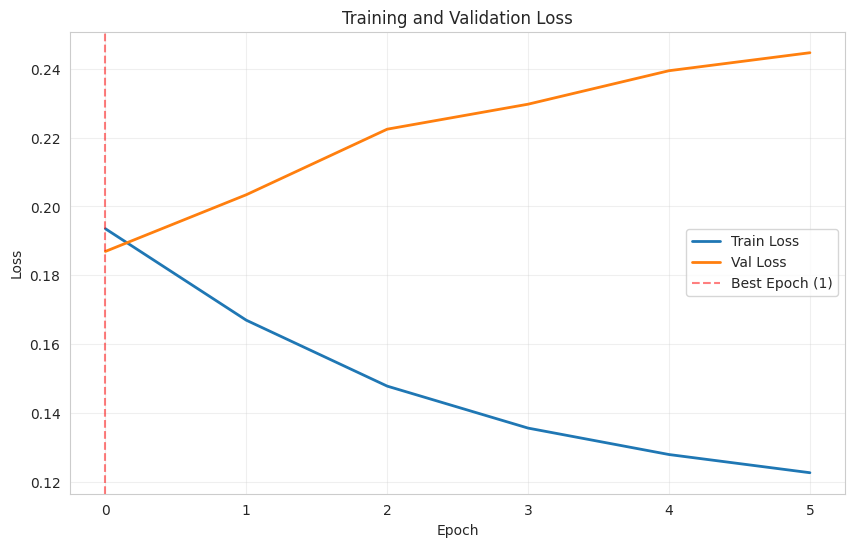

In [ ]:
print("\n" + "="*70)
print("STEP 2: Training Model")
print("="*70)

model = MinesweeperResNet(
    in_channels=3,
    num_residual_blocks=NUM_RESIDUAL_BLOCKS,
    dropout=DROPOUT
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_losses, val_losses = train_model_improved(
    model,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    device=device
)


STEP 3: Evaluation

Evaluating Logic Bot...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


Evaluating Neural Bot...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


Comparison on EASY difficulty
Metric                              Logic Bot         Neural Bot       
----------------------------------------------------------------------
Win Rate                            0.775 0.960
Avg Cells Revealed                  384.8 419.5
Std Cells Revealed                  131.6 76.0
Avg Mines Triggered                 0.240 0.070



/tmp/ipython-input-1129367003.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([logic_stats['cells_revealed'], neural_stats['cells_revealed']],


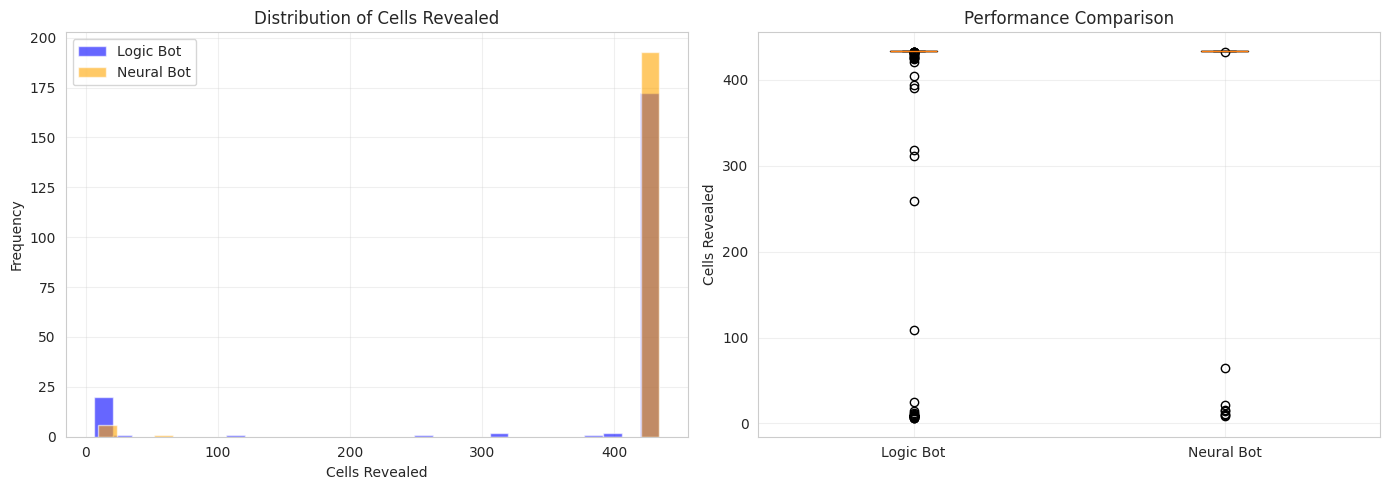

In [ ]:
print("\n" + "="*70)
print("STEP 3: Evaluation")
print("="*70)

if DIFFICULTY == 'easy':
    num_mines = 50
elif DIFFICULTY == 'medium':
    num_mines = 80
else:
    num_mines = 100

game = MinesweeperGame(num_mines=num_mines)

print("\nEvaluating Logic Bot...")
logic_bot = LogicBot(game)
logic_stats = evaluate_bot(logic_bot, game, num_games=200)

print("\nEvaluating Neural Bot...")
neural_bot = NeuralBot(model, device=device, epsilon=0.0)
neural_stats = evaluate_bot(neural_bot, game, num_games=200)  #pls ignore "comparision on medium difficulty" title if we're on easy or hard

compare_bots(logic_stats, neural_stats, DIFFICULTY)

## 10. Save Results

In [ ]:
save_path = f'minesweeper_model_{DIFFICULTY}_improved.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'difficulty': DIFFICULTY,
    'config': {
        'num_residual_blocks': NUM_RESIDUAL_BLOCKS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
    'logic_stats': logic_stats,
    'neural_stats': neural_stats
}, save_path)

print(f"Model saved to {save_path}")

if IN_COLAB:
    !cp {save_path} /content/drive/MyDrive/
    print(f"Model also saved to Google Drive")

Model saved to minesweeper_model_easy_improved.pth
Model also saved to Google Drive
